In [2]:
import pandas as pd
from datetime import datetime
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

from sklearn.neighbors import KNeighborsRegressor
from skopt import BayesSearchCV
import warnings

import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import PReLU
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
import random

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.inspection import permutation_importance

# Global constants to ensure consistency in the data
TIME_FMT = '%H:%M'
DATE_FMT = '%d-%m-%Y'

# Initial Data Load

The file, extracted from Kaggle, is a .csv format file. The file is loaded enforcing the date formating on the order date

In [5]:
df = pd.read_csv('zomato dataset.csv',parse_dates=['Order_Date'],date_format=DATE_FMT,dayfirst=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45584 entries, 0 to 45583
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ID                           45584 non-null  object        
 1   Delivery_person_ID           45584 non-null  object        
 2   Delivery_person_Age          43730 non-null  float64       
 3   Delivery_person_Ratings      43676 non-null  float64       
 4   Restaurant_latitude          45584 non-null  float64       
 5   Restaurant_longitude         45584 non-null  float64       
 6   Delivery_location_latitude   45584 non-null  float64       
 7   Delivery_location_longitude  45584 non-null  float64       
 8   Order_Date                   45584 non-null  datetime64[ns]
 9   Time_Orderd                  43853 non-null  object        
 10  Time_Order_picked            45584 non-null  object        
 11  Weather_conditions           44968 non-nu

# Initial Data Cleaning

The initial dataset contains 45,584 rows of data. However, there is a lot of unusable data so extensive 
data cleaning is required. As the data set was large any incomplete rows were simply removed.

The cleaning takes part in 7 steps
1. There are man rows where the data for the longitude or latitude values are negative which is not possible as the data is sourced from India. There rows were removed.
2. The naming convention used for the columns needed tidying to remove issues that could arise whilst manipulating the data.
3. There are quite a few duplicates in the dataset and following a little research on the Kaggle data set the duplicates were removed.
4. The times provided were the order time, the pick time and the overall delivery time. For this exercise I am interested in the travel time so this had to be calculate. Care was needed here as an order may be placed before midnight and delivered after. Travel time is in minutes. There was also inconsistency in teh format of the date and times which needed to be tidied up.
5.  The next field that is required is the travel distance. The data supplied identified the longitude and latitude of the locations. The haversine function was established to caluldate the distance between the locations.
6.  There was some data e.g. order date that is not interesting for this exercise so it was removed from the dataset.
7.  Finally there were some fields with literal values in them that needed to be converted to number fields. This created a lot of extra fields (maybe I change this)

In [8]:
df

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken (min)
0,0xcdcd,DEHRES17DEL01,36.0,4.2,30.327968,78.046106,30.397968,78.116106,2022-02-12,21:55,22:10,Fog,Jam,2,Snack,motorcycle,3.0,No,Metropolitian,46
1,0xd987,KOCRES16DEL01,21.0,4.7,10.003064,76.307589,10.043064,76.347589,2022-02-13,14:55,15:05,Stormy,High,1,Meal,motorcycle,1.0,No,Metropolitian,23
2,0x2784,PUNERES13DEL03,23.0,4.7,18.562450,73.916619,18.652450,74.006619,2022-03-04,17:30,17:40,Sandstorms,Medium,1,Drinks,scooter,1.0,No,Metropolitian,21
3,0xc8b6,LUDHRES15DEL02,34.0,4.3,30.899584,75.809346,30.919584,75.829346,2022-02-13,09:20,09:30,Sandstorms,Low,0,Buffet,motorcycle,0.0,No,Metropolitian,20
4,0xdb64,KNPRES14DEL02,24.0,4.7,26.463504,80.372929,26.593504,80.502929,2022-02-14,19:50,20:05,Fog,Jam,1,Snack,scooter,1.0,No,Metropolitian,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45579,0x7c09,JAPRES04DEL01,30.0,4.8,26.902328,75.794257,26.912328,75.804257,2022-03-24,11:35,11:45,Windy,High,1,Meal,motorcycle,0.0,No,Metropolitian,32
45580,0xd641,AGRRES16DEL01,21.0,4.6,0.000000,0.000000,0.070000,0.070000,2022-02-16,19:55,20:10,Windy,Jam,0,Buffet,motorcycle,1.0,No,Metropolitian,36
45581,0x4f8d,CHENRES08DEL03,30.0,4.9,13.022394,80.242439,13.052394,80.272439,2022-03-11,23:50,24:05:00,Cloudy,Low,1,Drinks,scooter,0.0,No,Metropolitian,16
45582,0x5eee,COIMBRES11DEL01,20.0,4.7,11.001753,76.986241,11.041753,77.026241,2022-03-07,13:35,13:40,Cloudy,High,0,Snack,motorcycle,1.0,No,Metropolitian,26


In [10]:
# Rows with negative or zero longitude or latitude are removed.
# Any rows with NaN are also removed

df = df.dropna()
df = df[df['Restaurant_latitude'] > 0]
df = df[df['Restaurant_longitude'] > 0]
df = df[df['Delivery_location_latitude'] > 0]
df = df[df['Delivery_location_longitude'] > 0]


In [12]:
# Rename the field to make all fields accessible when coding later
# Shift all column names to lower case

df.drop(['ID'], inplace=True, axis=1)
df.rename(columns={'Time_taken (min)':'Time_taken_min'}, inplace=True)
df.columns = [c.lower() for c in df.columns]


In [14]:
# Remove the duplicates the dataset identifed by the same person or the same age 
# with the same order date and same order time.

df = df[~df.duplicated(subset=['delivery_person_id','delivery_person_age','order_date','time_orderd'], keep=False)]


In [16]:
# Calculating the travel time. Initially multiple formats for the time need to be sorted
# then the time calculate.
# The time that I am using is the actual travelling time so this needs to be calculated from the 
# times available in the dataset. Remove any negative time differences as this is eroneous data

df['time_orderd'] = pd.to_datetime(df['time_orderd'], errors='coerce', format='%H:%M')
df['time_order_picked'] = pd.to_datetime(df['time_order_picked'], errors='coerce', format='%H:%M')

# For any rows that failed to convert (NaT), try with HH:MM:SS
df['time_orderd'] = df['time_orderd'].fillna(pd.to_datetime(df['time_orderd'], errors='coerce', format='%H:%M:%S'))
df['time_order_picked'] = df['time_order_picked'].fillna(pd.to_datetime(df['time_order_picked'], errors='coerce', format='%H:%M:%S'))

# Remove the seconds by formatting the datetime object to 'HH:MM'
df['time_orderd'] = df['time_orderd'].dt.strftime('%H:%M')
df['time_order_picked'] = df['time_order_picked'].dt.strftime('%H:%M')

df['time_orderd'] = pd.to_datetime(df['time_orderd'], format='%H:%M')
df['time_order_picked'] = pd.to_datetime(df['time_order_picked'], format='%H:%M')

# Adjust for cases where time_order_picked might be after midnight (next day)
df.loc[df['time_order_picked'] < df['time_orderd'], 'time_order_picked'] += pd.Timedelta(days=1)

# Calculate the time difference in minutes
df['time_diff_minutes'] = (df['time_order_picked'] - df['time_orderd']).dt.total_seconds() / 60
df = df.dropna()
print(df.shape)

# we have the time from ordering so now lets add a travel time
df['travel_time'] = df['time_taken_min'] - df['time_diff_minutes']
df = df[df['travel_time'] >= 0]
print(df.shape)


(30628, 20)
(29890, 21)


In [18]:
# The data contains the longitude and latitude of the start and end location
# The haversine function below calculates the distance between the two locations.
# A new column is added 'distance_km' to hold this data.
# Once the distance is calculated the longitude and latitude data is removed as it no longer needed.


# Define the Haversine formula
def haversine(lon1, lat1, lon2, lat2):
    # Convert latitude and longitude from degrees to radians
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Radius of Earth in kilometers (use 3956 for miles)
    R = 6371.0
    distance = R * c

    return distance


# Calculate the distance using the Haversine formula and add it as a new column
df['distance_km'] = df.apply(lambda row: haversine(row['restaurant_longitude'], row['restaurant_latitude'], 
                                                   row['delivery_location_longitude'], row['delivery_location_latitude']), axis=1)

df.drop(['restaurant_latitude'], inplace=True, axis=1)
df.drop(['restaurant_longitude'], inplace=True, axis=1)
df.drop(['delivery_location_latitude'], inplace=True, axis=1)
df.drop(['delivery_location_longitude'], inplace=True, axis=1)


In [20]:
# Remove fields that are not interesting to us or now obsolete

df.drop(['order_date'], inplace=True, axis=1)
df.drop(['delivery_person_id'], inplace=True, axis=1)
df.drop(['time_orderd'], inplace=True, axis=1)
df.drop(['time_order_picked'], inplace=True, axis=1)
df.drop(['time_diff_minutes'], inplace=True, axis=1)
df.drop(['time_taken_min'], inplace=True, axis=1)

In [22]:
# Convert fields from text values to numeric
# The function convert_fields was defined in order to encode the small number of values available
# in each field into specific fields with 1 or 0 to represent whether the condition applied.
# The original fields were then dropped

def convert_fields(df, field_name):
    df_encoded = pd.get_dummies(df, columns=[field_name], drop_first=False)
    dummy_columns = df_encoded.columns.difference(df.columns)
    df_encoded[dummy_columns] = df_encoded[dummy_columns].astype(int)
    df = pd.concat([df, df_encoded[dummy_columns]], axis=1)   
    df.drop([field_name], inplace=True, axis=1)
    return df

df = convert_fields(df,'city')
df = convert_fields(df, 'weather_conditions')
df = convert_fields(df, 'type_of_order')
df = convert_fields(df, 'type_of_vehicle')
df = convert_fields(df, 'road_traffic_density')

df['festival'] = df['festival'].map({'Yes': 1, 'No': 0}).astype(int)

df.info()

min_value = df['travel_time'].min()
max_value = df['travel_time'].max()

print(f"Minimum travel time: {min_value}")
print(f"Maximum travel time: {max_value}")

<class 'pandas.core.frame.DataFrame'>
Index: 29890 entries, 0 to 45583
Data columns (total 27 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   delivery_person_age               29890 non-null  float64
 1   delivery_person_ratings           29890 non-null  float64
 2   vehicle_condition                 29890 non-null  int64  
 3   multiple_deliveries               29890 non-null  float64
 4   festival                          29890 non-null  int64  
 5   travel_time                       29890 non-null  float64
 6   distance_km                       29890 non-null  float64
 7   city_Metropolitian                29890 non-null  int64  
 8   city_Semi-Urban                   29890 non-null  int64  
 9   city_Urban                        29890 non-null  int64  
 10  weather_conditions_Cloudy         29890 non-null  int64  
 11  weather_conditions_Fog            29890 non-null  int64  
 12  weather_c

# Optimisation starts from here

## Setup the datasets, training data and test data. Common for all optimizations

In [143]:
# Prepare the data for processing in each of the optimizations

X = df.drop(columns=['travel_time'])
y = df['travel_time']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Using Scalers as linerRegression performs better
scaler = StandardScaler()

# Fit on the training data and transform both training and test sets
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

results_df = pd.DataFrame(columns=['Optimization Type', 'RMSE'])


## Linear Regression 

In [146]:
# Initialize the Linear Regression model
model = LinearRegression(fit_intercept=True,  copy_X=True, n_jobs=-1)

# Train the model on the training data
model.fit(X_train_scaler, y_train)

# Predict on the test set
y_pred = model.predict(X_test_scaler)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R^2 Score: {r2}")

new_result = pd.DataFrame({'Optimization Type': 'Linear Regression', 'RMSE': [rmse]})
results_df = pd.concat([results_df, new_result], ignore_index=True)

RMSE: 7.0543419703675365
R^2 Score: 0.49087764773724163


/var/folders/8j/k0l1t8bd5bb0xcj205_9p_fw0000gn/T/ipykernel_55458/1871477611.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_result], ignore_index=True)


## Hyper Parameter Tuning for Linear Regression

There is little tuning to be done on the LinerRegression.

Changing fit_intercept=False has a very negative impact on the performance

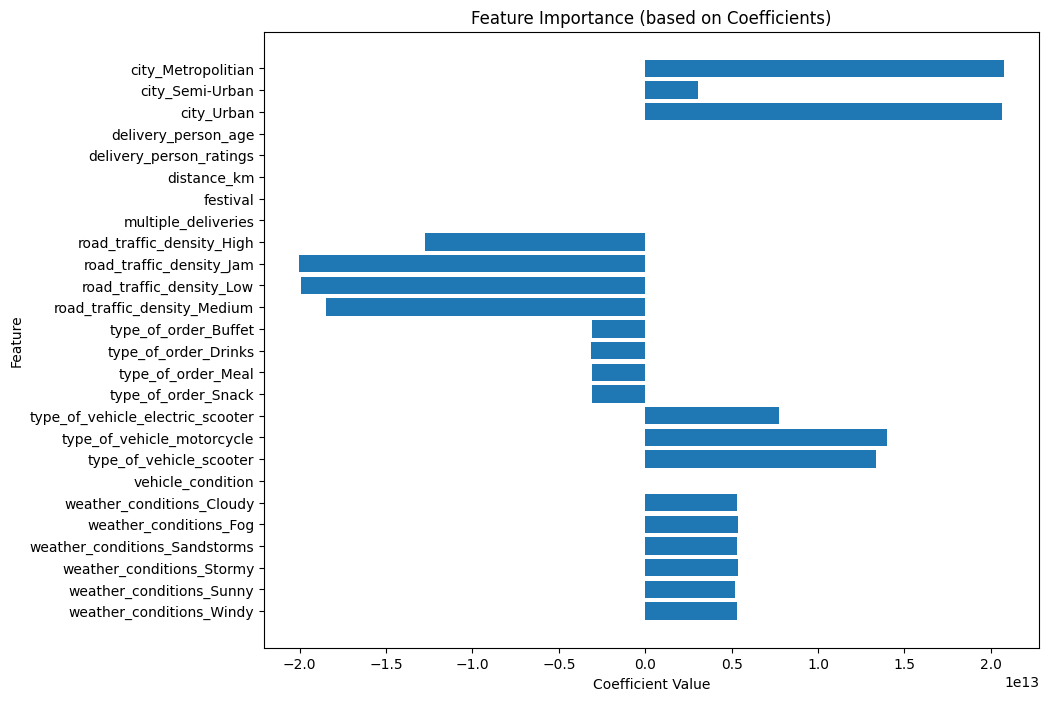

In [149]:
coefficients = model.coef_

feature_importance_1 = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
}).sort_values(by='Feature',  ascending=True)

#print(feature_importance)

# Create a horizontal bar plot for feature importance
plt.figure(figsize=(10, 8))  # Adjust the size of the plot if necessary
plt.barh(feature_importance_1['Feature'], feature_importance_1['Coefficient'])

# Invert the order to have the largest at the top
plt.gca().invert_yaxis()

plt.title('Feature Importance (based on Coefficients)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

# Positive coefficient: A positive value means that as the feature increases, the target 
# (travel time, in your case) also increases.
# Negative coefficient: A negative value means that as the feature increases, the target decreases.
# Larger absolute value: A larger absolute value of a coefficient indicates a stronger 
# influence on the target variable.


## GridSearch

In [152]:
# Define the model
ridge = Ridge()

# Define the hyperparameter grid
param_grid = {
    'alpha': [0.1, 1, 10, 100],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag', 'saga'],
}

# Set up the grid search
grid_search = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=5, refit=True )

# Fit the grid search to the data
grid_search.fit(X_train_scaler, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Predict and evaluate
y_pred = best_model.predict(X_test_scaler)
mse = mean_squared_error(y_test, y_pred)
print(f"Best alpha: {grid_search.best_params_['alpha']} Solver: {grid_search.best_params_['solver']}, MSE: {mse}")

rmse = mse ** 0.5
print(f"RMSE : {rmse}")

new_result = pd.DataFrame({'Optimization Type': 'GridSearchCV using Ridge', 'RMSE': [rmse]})
results_df = pd.concat([results_df, new_result], ignore_index=True)
results_df



Best alpha: 10 Solver: sag, MSE: 49.752195988059654
RMSE : 7.053523657581341


,Optimization Type,RMSE
0,Linear Regression,7.054342
1,GridSearchCV using Ridge,7.053524


## Hyper Parameter Tuning for GridSearch

The nature of gridsearch means that it is the function that identifies the best parameters from those allowed.

In this case the best values were alpha of 10, Solver of Saga returning an MSE of 49.752 and an RMSE of 7.0535

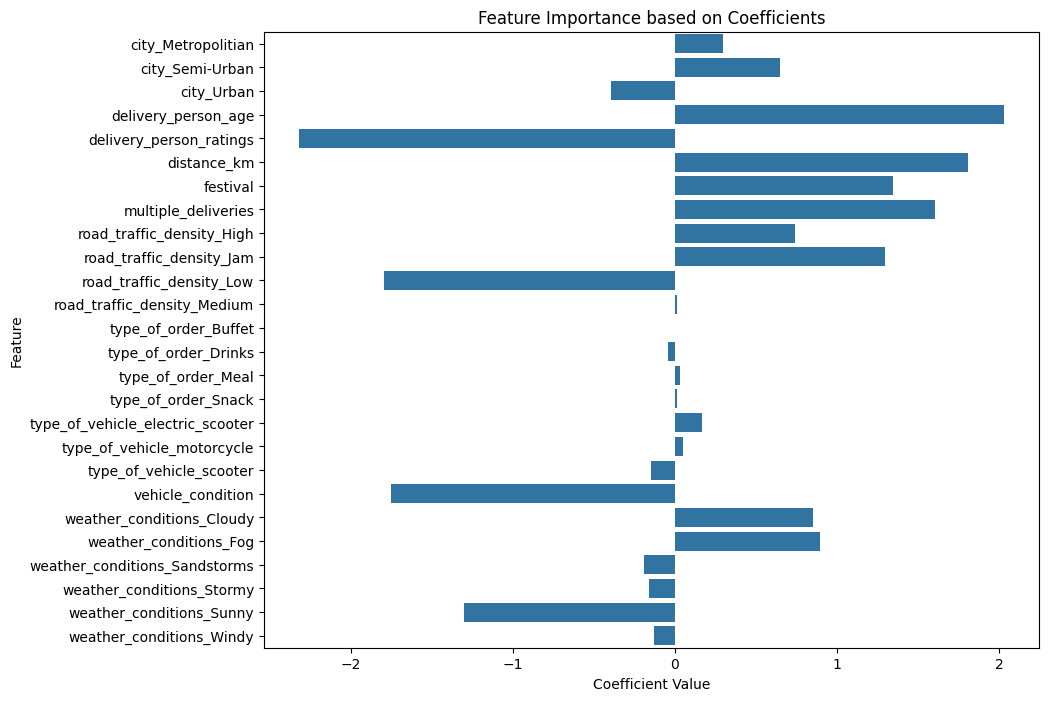

In [38]:
# Assuming GridSearchCV has been fitted with a linear model
best_model = grid_search.best_estimator_  # Get the best model from GridSearchCV
coefficients = best_model.coef_

# Create a DataFrame to hold feature importance
feature_importance_2 = pd.DataFrame({
    'Feature': X.columns,               # Replace X with your feature DataFrame
    'Coefficient': coefficients
}).sort_values(by='Feature',  ascending=True)

# Print the feature importance
#print(feature_importance_2)

# Visualization


plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance_2)
plt.title('Feature Importance based on Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

## Bayesian Optimisation using RandomForestRegressor

In [154]:
# using random forest so scaler data not used
model = RandomForestRegressor()

# Define the search space for hyperparameters
param_space = {
    'n_estimators': (100, 500),  # Number of trees in the forest
    'max_depth': list(range(3, 16)) + [None],  # Maximum depth of the tree
    'min_samples_split': (2, 20),  # Minimum samples required to split an internal node
}

# Set up the Bayesian optimization
warnings.filterwarnings("ignore", category=UserWarning)
opt = BayesSearchCV(model, param_space, n_iter=50, scoring='neg_mean_squared_error', cv=5, random_state=42, n_jobs=-1 )

# Fit the model
opt.fit(X_train, y_train)

# Predict on the test set
y_pred = opt.predict(X_test)

# Evaluate the best model found
mse = mean_squared_error(y_test, y_pred)
print(f"Best Hyperparameters: {opt.best_params_}")
print(f"Test MSE: {mse}")

print(f'Best parameters: {opt.best_params_}')
print(f'Best cross-validated MSE: {-opt.best_score_}')

rmse = mse ** 0.5
print(f"RMSE : {rmse}")

new_result = pd.DataFrame({'Optimization Type': 'BayesSearch Random Forest', 'RMSE': [rmse]})
results_df = pd.concat([results_df, new_result], ignore_index=True)
results_df


Best Hyperparameters: OrderedDict([('max_depth', 11), ('min_samples_split', 20), ('n_estimators', 393)])
Test MSE: 29.25166626350772
Best parameters: OrderedDict([('max_depth', 11), ('min_samples_split', 20), ('n_estimators', 393)])
Best cross-validated MSE: 30.209772348784195
RMSE : 5.408480957117971


,Optimization Type,RMSE
0,Linear Regression,7.054342
1,GridSearchCV using Ridge,7.053524
2,BayesSearch Random Forest,5.408481


## Hyper Parameter Tuning on Bayesian Optimisation with RandomForest Regressor

Utilising Random Forest the key parameters changed were
    n_estimators (10,500)
    max_depth list(range(1,11))
    min_samples_split': (2, 80)

Having these values gave the best output, although reducing the values did worsen the output it wasn't too significant meaning the RandomForest was performing quite well for the given data.

The output from the BayesianSearchCV was 
max_depth = 11
min_sample_split = 18
n_estimators = 260

and and MSE of 29.2829 wuth and RMSE of 5.4113


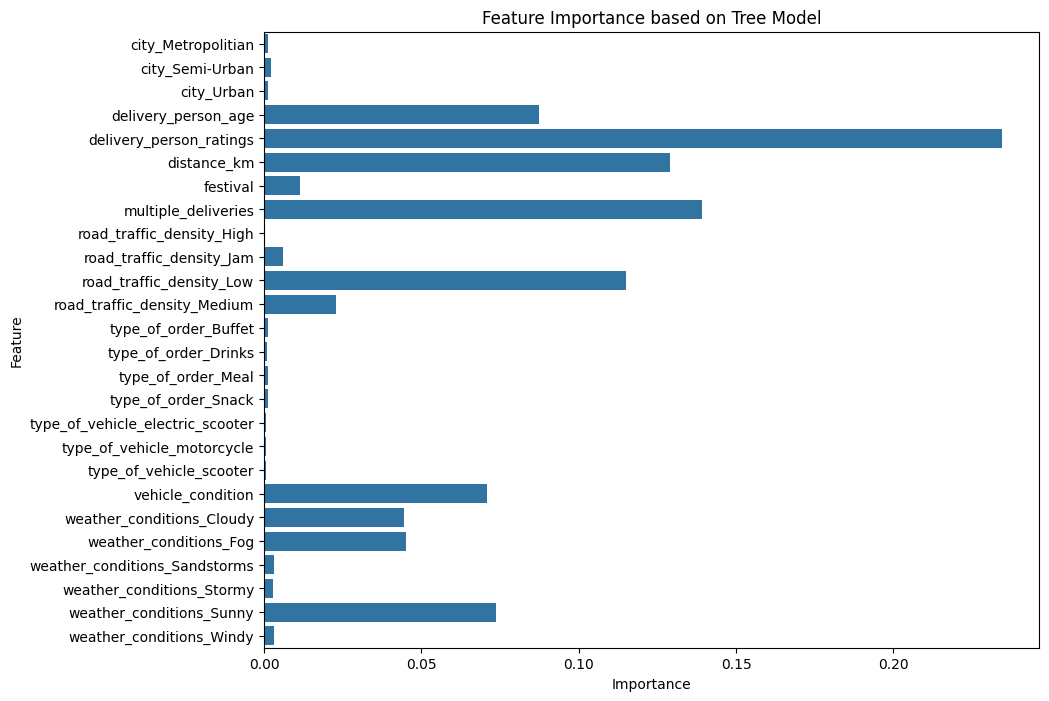

In [157]:
# Assuming BayesSearchCV is fitted
best_model = opt.best_estimator_

# Get feature importance for tree-based models
importances = best_model.feature_importances_

# Create a DataFrame for feature importance
feature_importance_3 = pd.DataFrame({
    'Feature': X.columns,                # Replace X with your feature DataFrame
    'Importance': importances
}).sort_values(by='Feature', ascending=True)

# Print the feature importance
#print(feature_importance_3)

# Visualization
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_3)
plt.title('Feature Importance based on Tree Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


## Bayesian Optimisation using SVR

In [159]:
# Initialize the SVR model
model = SVR()

# Define the search space for hyperparameters. This was used for the early runs but then 
# the below was used to speed up the execution time. The data shown in the param_space was defined
# by running the algorithm with param_space1
param_space1 = {
    'C': (0.1, 1000),  # Regularization parameter
    'epsilon': (0.01, 0.5),  # Epsilon in the epsilon-SVR model
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
}

param_space = {
    'C': [837.404616717729],  # Regularization parameter
    'epsilon': [0.4428244859166225],  # Epsilon in the epsilon-SVR model
    'kernel': [ 'poly'],  # Kernel type
}

# Set up the Bayesian optimization
#warnings.filterwarnings("ignore", category=UserWarning)
opt = BayesSearchCV(model, param_space, n_iter=10, scoring='neg_mean_squared_error', cv=5, random_state=42, n_jobs=-1)

# Fit the model
opt.fit(X_train, y_train)

# Predict on the test set
y_pred = opt.predict(X_test)

# Evaluate the best model found
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse}")

print(f'Best parameters: {opt.best_params_}')
print(f'Best cross-validated MSE: {-opt.best_score_}')

rmse = mse ** 0.5
print(f"RMSE : {rmse}")

new_result = pd.DataFrame({'Optimization Type': 'BayesSearch SVR', 'RMSE': [rmse]})
results_df = pd.concat([results_df, new_result], ignore_index=True)
results_df


Test MSE: 42.469491322081694
Best parameters: OrderedDict([('C', 837.404616717729), ('epsilon', 0.4428244859166225), ('kernel', 'poly')])
Best cross-validated MSE: 42.29096953084214
RMSE : 6.5168620763433145


,Optimization Type,RMSE
0,Linear Regression,7.054342
1,GridSearchCV using Ridge,7.053524
2,BayesSearch Random Forest,5.408481
3,BayesSearch SVR,6.516862


## Hyper Parameter Tuning on Bayesian Optimisation with SVR

This process was extremly slow. Therefore given the limited time some assumptions had to be made.

The inital runs were set with a cv as 5 and n_iter as 5. Any higher values were taking far to long (hours) to respond. These runs were executed with the values in param_space1 and the following output was detemermined.

Test MSE: 42.469491322081694
Best parameters: OrderedDict([('C', 837.404616717729), ('epsilon', 0.4428244859166225), ('kernel', 'poly')])
Best cross-validated MSE: 42.62412126670575
RMSE : 6.5168620763433145

Therefore, the values of param_space were setup and used in the optimization run. With these cv was moved to 5 and n_iter = 10. The values output values didn't change.



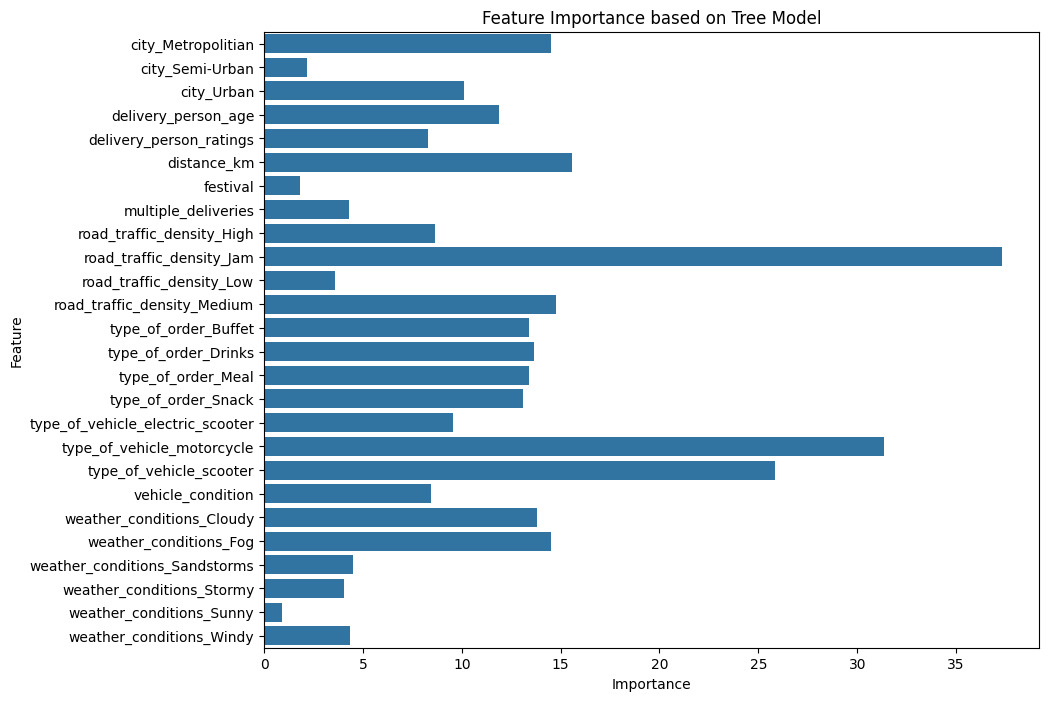

In [161]:
result = permutation_importance(opt, X_test, y_test, n_repeats=30, 
                                random_state=42, scoring='neg_mean_squared_error', n_jobs=-1)

# Get the feature importance
importance = result.importances_mean

# Create a DataFrame for visualization
importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
importances_df.sort_values(by='Feature', ascending=True, inplace=True)

feature_importance_5 = importances_df.copy()

# Visualization
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_5)
plt.title('Feature Importance based on Tree Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Bayesian Optimisation using K-Nearest Neighbour

In [163]:
model = KNeighborsRegressor()

# Define the search space for hyperparameters
param_space = {
    'n_neighbors': (1, 30),  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm used to compute the nearest neighbors
}

# Set up the Bayesian optimization
warnings.filterwarnings("ignore", category=UserWarning)
opt = BayesSearchCV(model, param_space, n_iter=50, scoring='neg_mean_squared_error', cv=5, random_state=42, n_jobs=-1)

# Fit the model
opt.fit(X_train, y_train)

# Predict on the test set
y_pred = opt.predict(X_test)

# Evaluate the best model found
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse}")
print(f'Best parameters: {opt.best_params_}')
print(f'Best cross-validated MSE: {-opt.best_score_}')
rmse = mse ** 0.5
print(f"RMSE : {rmse}")

new_result = pd.DataFrame({'Optimization Type': 'BayesSearch KNearest', 'RMSE': [rmse]})
results_df = pd.concat([results_df, new_result], ignore_index=True)
results_df


Test MSE: 46.12566331198787
Best parameters: OrderedDict([('algorithm', 'auto'), ('n_neighbors', 13), ('weights', 'distance')])
Best cross-validated MSE: 46.51743026677134
RMSE : 6.791587687130887


,Optimization Type,RMSE
0,Linear Regression,7.054342
1,GridSearchCV using Ridge,7.053524
2,BayesSearch Random Forest,5.408481
3,BayesSearch SVR,6.516862
4,BayesSearch KNearest,6.791588


## Hyper Parameter Tuning on Bayesian Optimisation with KNeighbour Regressor

The algorithm ran with the param_space variable set with the values as above. This algoirthm ran quite quickly so no need to reduce the scope of the running.

The output showed that:-
    algorithm = 'auto'
    n_neighbours = 13,
    weights = distance

These values gave a RMSE of 6.79158
    


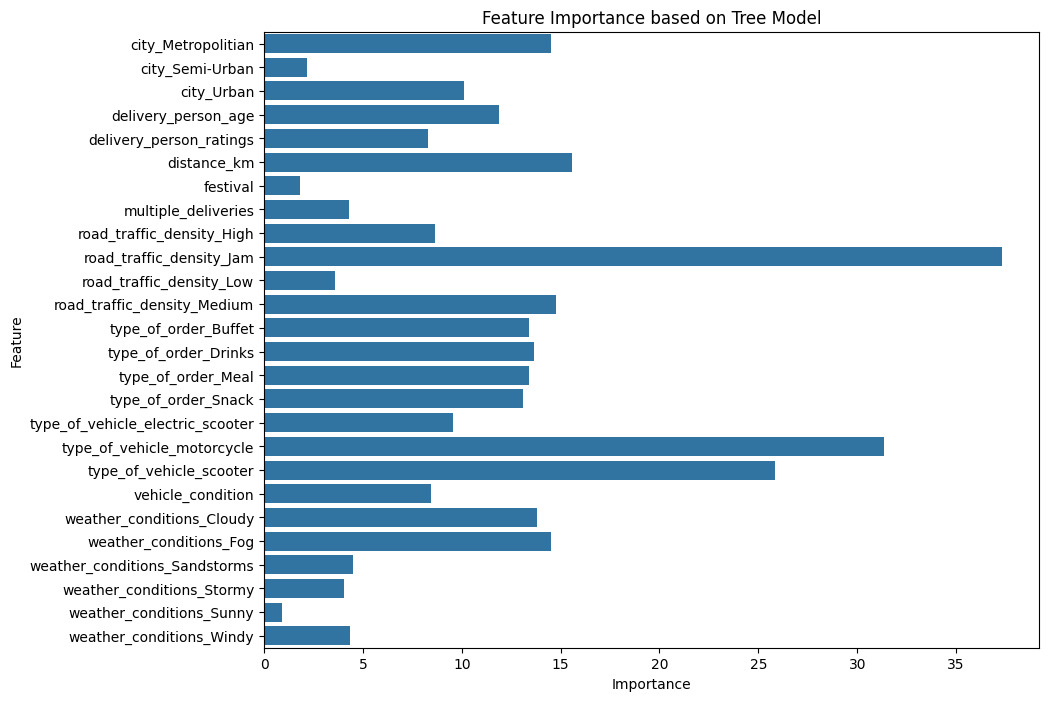

In [165]:
result = permutation_importance(opt, X_test, y_test, n_repeats=30, 
                                random_state=42, scoring='neg_mean_squared_error', n_jobs=-1)

# Get the feature importance
importance = result.importances_mean

# Create a DataFrame for visualization
importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
importances_df.sort_values(by='Feature', ascending=True, inplace=True)

feature_importance_6 = importances_df.copy()

# Visualization
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_5)
plt.title('Feature Importance based on Tree Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Neural Network Optimisation

In [168]:
random.seed(42) 
tf.random.set_seed(42)

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()


# Define the model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))  # Input layer
model.add(Dense(32, activation='relu'))  # Hidden layer
model.add(Dense(32, activation='relu'))  # Hidden layer
model.add(Dense(16, activation='relu'))  # Hidden layer
model.add(Dense(1))  # Output layer for regression

#model.add(Dense(64,  input_shape=(X_train_scaled.shape[1],)))  # Input layer
#model.add(LeakyReLU(alpha=0.01))  # Apply LeakyReLU activation
#model.add(Dense(32))
#model.add(LeakyReLU(alpha=0.01))
#model.add(Dense(32))
#model.add(LeakyReLU(alpha=0.01))
#model.add(Dense(16))
#model.add(LeakyReLU(alpha=0.01))
#model.add(Dense(1))

#model.add(Dense(64,  input_shape=(X_train_scaled.shape[1],)))  # Input layer
#model.add(PReLU())  # Apply LeakyReLU activation
#model.add(Dense(32))
#model.add(PReLU())  # Apply LeakyReLU activation
#model.add(Dense(32))
#model.add(PReLU())  # Apply LeakyReLU activation
#model.add(Dense(16))
#model.add(PReLU())  # Apply LeakyReLU activation
#model.add(Dense(1))

learning_rate = 0.001  # Change this value as needed

# Create the optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Code for compliling different optimisation functions.
# Compile the model
#model.compile(optimizer=SGD(learning_rate=0.01), loss='mean_squared_error', metrics=['mae'])
#model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='mean_squared_error', metrics=['mae'])

model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=200, batch_size=64, validation_split=0.2, verbose=0)

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test_scaled, y_test, verbose=0)
rmse = np.sqrt(test_loss)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}, RMSE : {rmse}')

# Make predictions
predictions = model.predict(X_test_scaled, verbose=0)

new_result = pd.DataFrame({'Optimization Type': 'Neural Network', 'RMSE': [rmse]})
results_df = pd.concat([results_df, new_result], ignore_index=True)
results_df


Test Loss: 33.058311462402344, Test MAE: 4.6408915519714355, RMSE : 5.749635767803239


,Optimization Type,RMSE
0,Linear Regression,7.054342
1,GridSearchCV using Ridge,7.053524
2,BayesSearch Random Forest,5.408481
3,BayesSearch SVR,6.516862
4,BayesSearch KNearest,6.791588
5,Neural Network,5.749636


# Hyper Parameter Tuning

Before tuning started the random.seed was set to 42 to bring some consistency to the results. Also multiple values were tried in the code above however only the successful entries remain. Where different calls were need i.e. not just value changes, the code has been commented out.

Various values were tried for the Neural network model with respect to the number of nodes including adding
more hidden layers and adjusting the number of nodes in each layer. The combination above gave the best performance with a Test Loss : 34.0176 and a Test MAE : 4.732 and a learning rate of 0.001

Changing the learning rate to smaller or larger values only reduced the performance of the network.

Changing the batch size from 32 to 64 gave some improvement with a Test Loss : 33.3818 and a Test MAE : 4.681

Changing the epoch size from 100 to 200 gave some improvement with a Test Loss : 33.0583 and a Test MAE : 4.641
Other values of epoch seemed to worsen the output although not signficantly. Dropping below 50 made a large negative difference.

Substituing ReLU with PReLU and LeakyReLU did not improve the result even when changing the alpha value of LeakyReLU.

SGD and RMSProp were tried as optimisers but neither, even with parameter changes could out perform Adam
                    

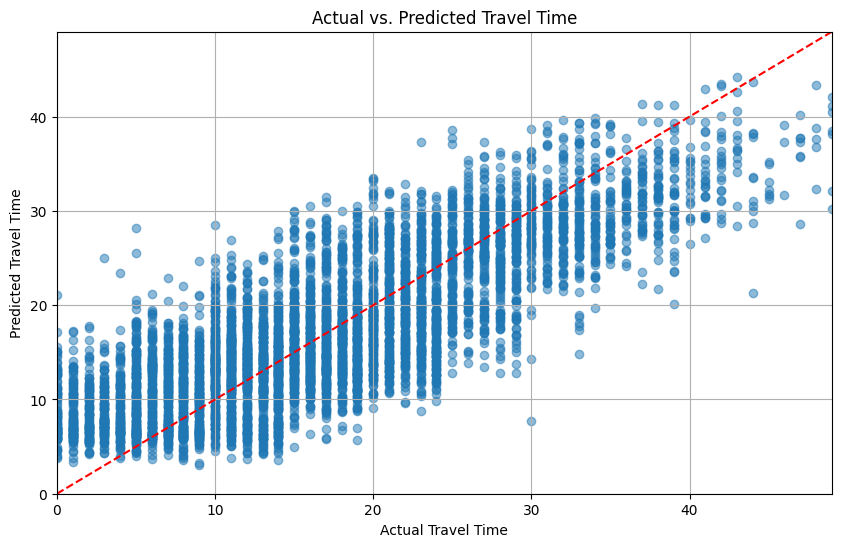

In [171]:
# Assuming you have the predictions from your model
# predictions = model.predict(X_test_scaled)

# Prepare actual vs predicted data
actual = y_test
predicted = predictions.flatten()  # Ensure it's a 1D array if necessary

plt.figure(figsize=(10, 6))
plt.scatter(actual, predicted, alpha=0.5)
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--')  # Line for perfect predictions
plt.title('Actual vs. Predicted Travel Time')
plt.xlabel('Actual Travel Time')
plt.ylabel('Predicted Travel Time')
plt.xlim(actual.min(), actual.max())
plt.ylim(actual.min(), actual.max())
plt.grid(True)
plt.show()


In [ ]:
# It has not been possible to find a way to make this command quiet ie verbose=0
# all guides point to methods to apply and non are working. The function though is working
# but creates a long log output which I have cleared to aid readability. Simply rerun if
# you want to see 192 rows of logs which have no value.

result = permutation_importance(model, X_test_scaled, y_test, n_repeats=30, 
                                random_state=42, scoring='neg_mean_squared_error', n_jobs=-1)

# Get the feature importance
importance = result.importances_mean

# Create a DataFrame for visualization
importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
importances_df.sort_values(by='Feature', ascending=True, inplace=True)

feature_importance_4 = importances_df.copy()





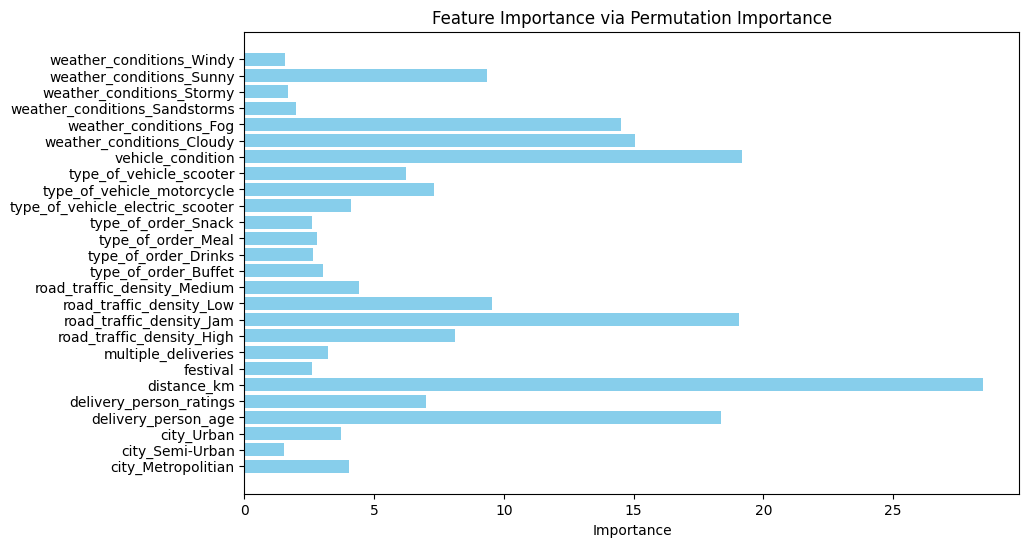

In [174]:
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance via Permutation Importance')
plt.show()

In [175]:


# Sort the features based on their importance in each model
sorted_features_1 = feature_importance_1['Feature'].tolist()
sorted_features_2 = feature_importance_2['Feature'].tolist()
sorted_features_3 = feature_importance_3['Feature'].tolist()
sorted_features_4 = feature_importance_4['Feature'].tolist()
sorted_features_5 = feature_importance_5['Feature'].tolist()
sorted_features_6 = feature_importance_6['Feature'].tolist()

# Combine the sorted features into a single DataFrame
sorted_importances = pd.DataFrame({
    'Model 1': sorted_features_1,
    'Model 2': sorted_features_2,
    'Model 3': sorted_features_3,
    'Model 4': sorted_features_4,
    'Model 5': sorted_features_5,
    'Model 6': sorted_features_6   
})

# rename two of the features
feature_importance_1 = feature_importance_1.rename(columns={'Coefficient': 'Importance'})
feature_importance_2 = feature_importance_2.rename(columns={'Coefficient': 'Importance'})

#print(feature_importance.info())
sorted_importances_values = pd.DataFrame({
    'Model 1 Importance': feature_importance_1['Importance'].abs().tolist(),
    'Model 2 Importance': feature_importance_2['Importance'].abs().tolist(),
    'Model 3 Importance': feature_importance_3['Importance'].abs().tolist(),
    'Model 4 Importance': feature_importance_4['Importance'].abs().tolist(),
    'Model 5 Importance': feature_importance_5['Importance'].abs().tolist(),
    'Model 6 Importance': feature_importance_6['Importance'].abs().tolist()
    
})

# Normalize the values to a [0, 1] scale for each model
normalized_importances = sorted_importances_values.apply(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Add the normalized values to the original DataFrame
sorted_importances_values[['Model 1 (Norm)', 'Model 2 (Norm)', 'Model 3 (Norm)', 'Model 4 (Norm)','Model 5 (Norm)','Model 6 (Norm)']] = normalized_importances


sorted_importances_values['Rank'] = sorted_importances_values[['Model 1 Importance', 
                                                                'Model 2 Importance', 
                                                                'Model 3 Importance', 
                                                                'Model 4 Importance',
                                                                'Model 5 Importance',
                                                                'Model 6 Importance']].mean(axis=1)

sorted_importances_values['Rank (Norm)'] = sorted_importances_values[['Model 1 (Norm)', 
                                                                'Model 2 (Norm)', 
                                                                'Model 3 (Norm)', 
                                                                'Model 4 (Norm)',
                                                                'Model 5 (Norm)',
                                                                'Model 6 (Norm)']].mean(axis=1)


sorted_importances_values['Feature'] = feature_importance_1['Feature'].tolist()




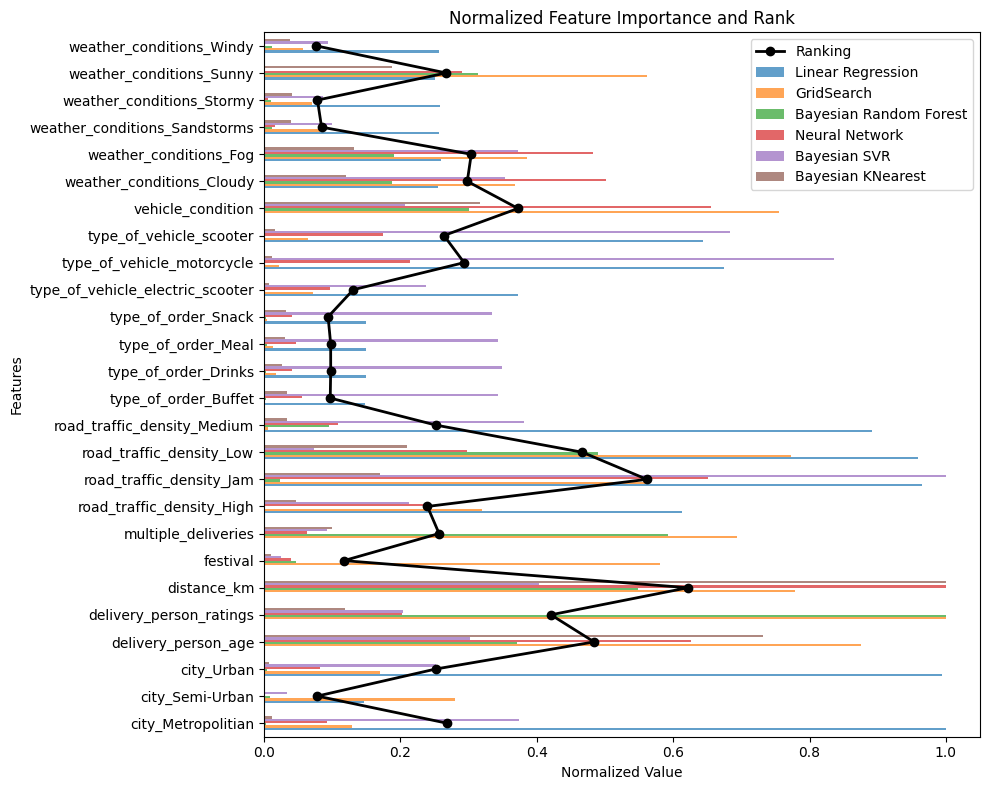

In [176]:
# Create a new DataFrame for plotting
plot_data = sorted_importances_values[['Feature', 'Model 1 (Norm)', 'Model 2 (Norm)', 
                                        'Model 3 (Norm)', 'Model 4 (Norm)', 'Model 5 (Norm)','Model 6 (Norm)','Rank (Norm)']]

# Set the feature names as the index for better plotting
plot_data.set_index('Feature', inplace=True)

# Plotting
plt.figure(figsize=(10, 8))

# Plotting the normalized importance values for each model
plot_data[['Model 1 (Norm)', 'Model 2 (Norm)', 'Model 3 (Norm)', 'Model 4 (Norm)', 'Model 5 (Norm)', 'Model 6 (Norm)']].plot(kind='barh', alpha=0.7, ax=plt.gca())

# Adding the normalized rank as a line plot on the same graph
plt.plot(plot_data['Rank (Norm)'], plot_data.index, marker='o', color='black', label='Rank (Norm)', linewidth=2)

# Customizing the plot
plt.title('Normalized Feature Importance and Rank')
plt.xlabel('Normalized Value')
plt.ylabel('Features')
new_labels = ['Ranking','Linear Regression', 'GridSearch', 'Bayesian Random Forest','Neural Network', 'Bayesian SVR','Bayesian KNearest']  
plt.legend(labels=new_labels)
#plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


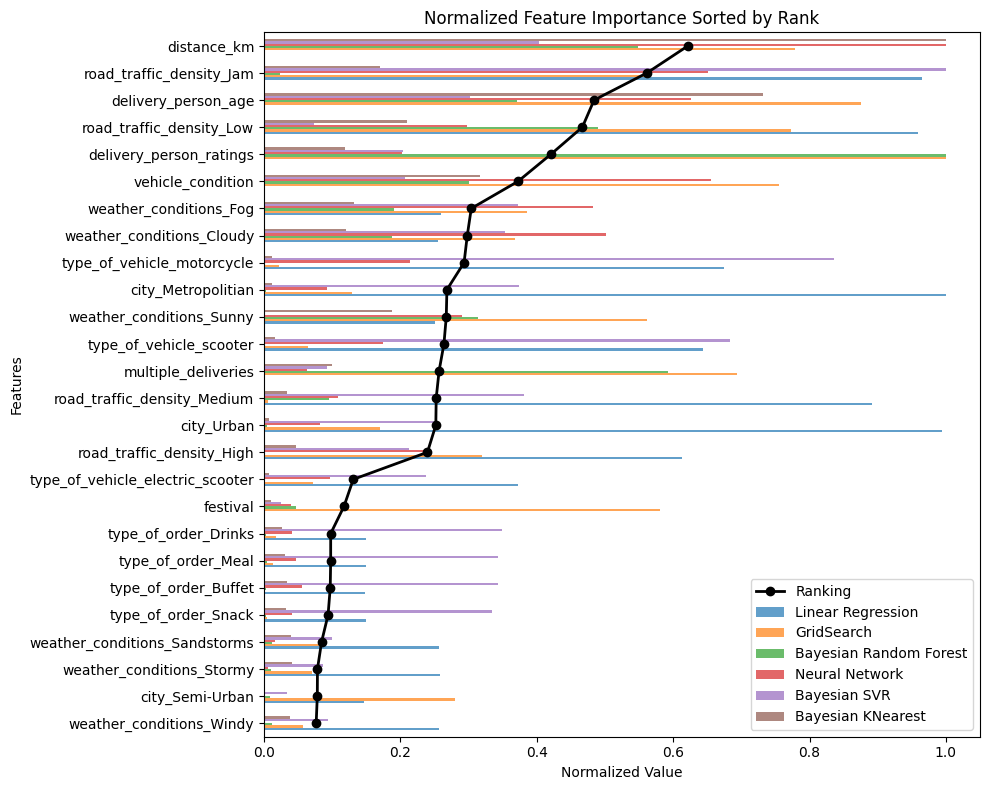

In [177]:
# Create a new DataFrame for plotting
plot_data = sorted_importances_values[['Feature', 'Model 1 (Norm)', 'Model 2 (Norm)', 
                                        'Model 3 (Norm)', 'Model 4 (Norm)', 'Model 5 (Norm)','Model 6 (Norm)','Rank (Norm)']]

# Set the feature names as the index for better plotting
plot_data.set_index('Feature', inplace=True)

# Sort the DataFrame by 'Rank (Norm)'
plot_data = plot_data.sort_values(by='Rank (Norm)', ascending=True)

# Plotting
plt.figure(figsize=(10, 8))

# Plotting the normalized importance values for each model
plot_data[['Model 1 (Norm)', 'Model 2 (Norm)', 'Model 3 (Norm)', 'Model 4 (Norm)', 'Model 5 (Norm)', 'Model 6 (Norm)']].plot(kind='barh', alpha=0.7, ax=plt.gca())

# Adding the normalized rank as a line plot on the same graph
plt.plot(plot_data['Rank (Norm)'], plot_data.index, marker='o', color='black', label='Rank (Norm)', linewidth=2)

# Customizing the plot
plt.title('Normalized Feature Importance Sorted by Rank')
plt.xlabel('Normalized Value')
plt.ylabel('Features')
pnew_labels = ['Ranking','Linear Regression', 'GridSearch', 'Bayesian Random Forest','Neural Network', 'Bayesian SVR','Bayesian KNearest']  
plt.legend(labels=new_labels)
plt.tight_layout()

# Show the plot
plt.show()


# How did each of the optimisations compare

In [192]:
results_df

,Optimization Type,RMSE
0,Linear Regression,7.054342
1,GridSearchCV using Ridge,7.053524
2,BayesSearch Random Forest,5.408481
3,BayesSearch SVR,6.516862
4,BayesSearch KNearest,6.791588
5,Neural Network,5.749636
